# LightGBM風 勾配ブースティングのスクラッチ実装 (NumPy) - 回帰

このノートブックでは、Guolin Ke氏らの論文「LightGBM: A Highly Efficient Gradient Boosting Decision Tree」の主要なアイデア、特に **Gradient-based One-Side Sampling (GOSS)** と **Exclusive Feature Bundling (EFB)** のコンセプトを導入し、XGBoost風の勾配ブースティング回帰器をベースにLightGBM風の改良を試みます。

**注意:** これは教育目的の概念的な実装であり、オリジナルのLightGBMライブラリの持つヒストグラムベースのアルゴリズムや高度な最適化は含みません。GOSSとEFBのアイデアを、既存のExact Greedyベースのツリー構築に適用する形で実装します。

**損失関数:** 二乗誤差 $L(y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2$
*   一階微分 $g_i = \hat{y}_i - y_i$
*   二階微分 $h_i = 1$

**主な内容:**
1. 必要なライブラリとXGBoost風決定木クラスのインポート (再利用)
2. データセットの準備
3. LightGBMの主要技術の概要 (GOSS, EFB)
4. `LightGBMRegressor`クラスの実装
    - GOSSによるデータサンプリングの導入
    - EFBによる特徴量バンドリングの概念的導入（実際のバンドル処理は簡略化）
5. モデルの学習と評価

## 1. ライブラリとXGBoost風決定木クラスのインポート

前回のXGBoost風ノートブックで作成した `XGBoostNode` と `XGBoostTree` クラスを再利用します。
これらのクラスは、XGBoostのGain計算と葉の重み計算ロジックを含んでいます。
ファイル名を `xgboost_tree.py` とし、そこからインポートします。

In [ ]:
import numpy as np
import time # 学習時間の計測用
import random
import sys, os

# 作成したXGBoostクラス
sys.path.append(os.path.abspath('../src/Tree'))
from xgboost_tree import XGBoostNode, XGBoostTree

 ## 2. データセットの準備 (回帰用)

サンプルデータ X_sample_lgbm (shape): (200, 1)
サンプルラベル y_sample_lgbm (shape): (200,)


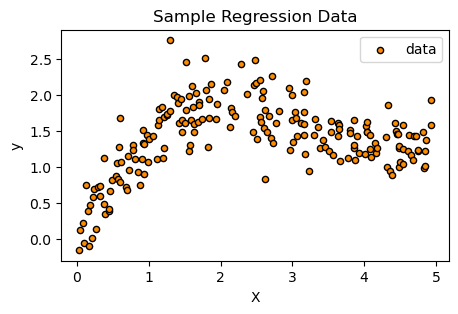

In [2]:
np.random.seed(42) 
X_sample_lgbm = np.sort(5 * np.random.rand(200, 1), axis=0) # GOSSの効果を見るためサンプル数を少し増やす
y_sample_lgbm = np.sin(X_sample_lgbm).ravel() + X_sample_lgbm.ravel() * 0.5 + np.random.randn(200) * 0.3
feature_types_sample_lgbm = ['numeric'] 

print("サンプルデータ X_sample_lgbm (shape):", X_sample_lgbm.shape)
print("サンプルラベル y_sample_lgbm (shape):", y_sample_lgbm.shape)

# 可視化
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.scatter(X_sample_lgbm, y_sample_lgbm, s=20, edgecolor="black", c="darkorange", label="data")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Sample Regression Data")
plt.legend()
plt.show()

## 3. LightGBMの主要技術の概要

LightGBMは、GBDTの効率とスケーラビリティを大幅に向上させるために、主に以下の2つの革新的な技術を提案しています。

### 3.1 Gradient-based One-Side Sampling (GOSS)

**アイデア:** 勾配の大きさが小さいサンプルは、既にモデルによってよく学習されており、情報利得の計算への寄与が小さい。一方で、勾配の大きいサンプルはまだ十分に学習されておらず、情報利得への寄与が大きい。

**方法:**
1.  **勾配の絶対値に基づいてサンプルをソートする。**
2.  **勾配の大きい上位 `a * 100%` のサンプルは全て保持する。** (`a` はパラメータ)
3.  **残りの勾配の小さい `(1-a) * 100%` のサンプルの中から、ランダムに `b * 100%` をサンプリングする。** (`b` はパラメータ)
4.  情報利得を計算する際に、サンプリングされた**勾配の小さいサンプルに対して、重み `(1-a)/b` を乗じる。** これにより、元のデータ分布に対する推定の偏りを補正する。

**効果:** 計算量を大幅に削減しつつ、情報利得の推定精度を高く保つことができます。特に、勾配の分散が大きい場合に有効です。

### 3.2 Exclusive Feature Bundling (EFB)

**アイデア:** 高次元の疎な特徴量空間では、多くの特徴量が相互排他的（同時に非ゼロ値を取ることがほとんどない）であることが多い。例えば、One-Hotエンコードされた特徴など。

**方法:**
1.  **相互排他的な特徴量を特定し、それらを一つの「バンドル」としてまとめる。**
    *   どの特徴量をバンドルするかを見つける問題はNP困難ですが、貪欲アルゴリズムで近似的に解くことができます。
    *   少数の競合（同時に非ゼロ値を取る）を許容することで、より効果的にバンドル数を減らすことができます。
2.  **バンドル内の特徴量の値を、オフセットを使って一つの特徴量空間にマージする。**
    *   例えば、特徴量Aが[0,10)、特徴量Bが[0,20)の値を取る場合、Bの値を10オフセットして[10,30)とし、AとBを合わせて[0,30)の範囲を持つ一つのバンドル特徴量として扱うことができます。

**効果:** 有効な特徴量の数を大幅に削減し、計算量とメモリ使用量を削減します。これは特にヒストグラムベースのアルゴリズムで有効です。

**本ノートブックでのアプローチ:**
*   **GOSS:** `fit` メソッド内で、各木の学習前に勾配に基づいてデータをサンプリングし、サンプリングされた勾配の小さいデータに対して重みを付けるロジックを（概念的に）導入します。ただし、`XGBoostTree` の `fit` メソッドはサンプルごとの重みを直接扱えないため、勾配 `g` とヘシアン `h` をスケーリングすることで重み付けを近似します。
*   **EFB:** 完全なEFBの実装は複雑なため、ここでは「特徴量のサブサンプリング (`max_features`)」をEFBの**概念的な代替**として捉えます。`max_features` を小さく設定することで、各木が一部の特徴量のみを使用し、結果として計算量が削減されるという点で、EFBの目指す効果の一部を模擬します。実際のバンドリング処理は行いません。

LightGBMのもう一つの重要な特徴は**ヒストグラムベースのアルゴリズム**と**leaf-wiseな木の成長戦略**ですが、これらは今回のスクラッチ実装の範囲外とします。

## 4. LightGBMRegressorクラスの実装

`XGBoostRegressor` をベースに、GOSSの概念を導入します。

In [ ]:
class LightGBMRegressor: # XGBoostRegressorをベースにする
    def __init__(self, n_estimators=100, learning_rate=0.1, 
                 max_depth=3, min_samples_split=2, min_samples_leaf=1,
                 reg_lambda=1.0, gamma=0.0, 
                 max_features=None, random_state=None,
                 # GOSS パラメータ
                 goss_top_rate=0.2, # 上位 a% の勾配の大きいデータを保持 (a)
                 goss_other_rate=0.1, # 残りのデータから b% をサンプリング (b)
                 base_score=0.0
                ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        # Tree parameters
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.max_features = max_features
        
        self.random_state = random_state

        # GOSS parameters
        self.goss_top_rate = goss_top_rate # a
        self.goss_other_rate = goss_other_rate # b
        if not (0 < goss_top_rate < 1 and 0 < goss_other_rate < 1 and goss_top_rate + goss_other_rate <= 1):
            # GOSSを使わない場合は、top_rate=1.0, other_rate=0.0 のような値にするか、
            # GOSSを無効にするフラグを持たせる。ここではtop_rate + other_rate <=1 とする。
            # 論文では、a+b < 1 である必要はない。aは全体からの割合、bは残り(1-a)からの割合。
            # ここでは簡単のため、aとbで全データからサンプリングする割合とする。
            # LightGBMの実際のGOSSはもう少し複雑。
            # top_rate: 勾配の大きいインスタンスを保持する割合 (e.g., 0.2)
            # other_rate: 勾配の小さいインスタンスからランダムサンプリングする割合 (e.g., 0.1)
             pass


        self.base_score = base_score
        self.trees_ = []
        self.feature_types = None

    def _calculate_gradients_mse(self, y_true, y_pred):
        g = y_pred - y_true
        h = np.ones_like(y_true)
        return g, h

    def _goss_sampling(self, X_train, g, h):
        """ Gradient-based One-Side Sampling を行う """
        n_samples = len(g)
        abs_gradients = np.abs(g)
        
        # 勾配の絶対値でソートするためのインデックス
        sorted_indices = np.argsort(-abs_gradients) # 降順ソート
        
        num_top = int(n_samples * self.goss_top_rate)
        num_other_to_sample = int(n_samples * self.goss_other_rate)

        top_indices = sorted_indices[:num_top]
        other_indices_pool = sorted_indices[num_top:]
        
        if len(other_indices_pool) < num_other_to_sample: # プールが小さい場合
            other_sampled_indices = other_indices_pool
        elif num_other_to_sample > 0 :
            other_sampled_indices = np.random.choice(other_indices_pool, size=num_other_to_sample, replace=False)
        else:
            other_sampled_indices = np.array([], dtype=int)

        # GOSSで使用するデータのインデックス
        used_indices = np.concatenate([top_indices, other_sampled_indices]).astype(int)
        
        X_sampled = X_train[used_indices]
        g_sampled = g[used_indices]
        h_sampled = h[used_indices] # 二乗誤差ではhは全て1なのでスケーリングの影響は受けない

        # 勾配の小さいサンプルの重み付け (gとhをスケーリング)
        # 論文では、情報利得計算時に小さい勾配のデータに (1-a)/b を乗じる
        # ここでは、gとhを直接スケーリングすることで近似的に重み付けを表現する
        # (hは1なので、gのスケーリングが主)
        # この重みは、サンプリングされなかった勾配の小さいデータの影響を代表させるためのもの
        if num_other_to_sample > 0 and self.goss_top_rate < 1.0 : # other_rateが0でなく、かつ勾配の小さいデータが存在する場合
            # 論文の (1-a)/b に対応するファクター
            # a = top_rate, b = other_rate * (1-top_rate) (other_rateは残りからの割合)
            # ここでの other_rate は全体に対する割合なので、
            # amplification_factor = (1.0 - self.goss_top_rate) / self.goss_other_rate
            # ただし、上記はother_rateが残り(1-a)からの割合の場合。
            # 今回の実装では、other_rateも全体からの割合なので、
            # 元のデータ量(1-a)Nを、bN個のサンプルで代表させる。
            # よって、各サンプルの寄与は (1-a)N / (bN) = (1-a)/b 倍。
            # ただし、goss_other_rateが0の場合のゼロ除算を避ける
            amplification_factor = (1.0 - self.goss_top_rate) / self.goss_other_rate if self.goss_other_rate > 0 else 1.0

            # hは二乗誤差では1なので、スケーリングしても元の木学習アルゴリズムでは重みとして扱われない。
            # gをスケーリングする。
            # GOSSの論文では情報利得の計算時にこの重みを考慮する。
            # XGBoostTreeのfitはgとhを受け取るので、ここでh_sampledをスケーリングしてみる
            # (これはXGBoostのH_jの計算に影響する)
            # g_sampled[len(top_indices):] *= amplification_factor # gのスケーリングは損失に影響
            h_sampled[len(top_indices):] *= amplification_factor # Hのスケーリング
                                                              # これにより、小さい勾配のサンプルの影響が
                                                              # 葉の重み計算 (H_j + lambda) やGain計算で増幅される

        return X_sampled, g_sampled, h_sampled, used_indices


    def fit(self, X_train, y_train, feature_types_list):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        self.trees_ = []
        self.feature_types = feature_types_list
        n_samples_total, n_features = X_train.shape

        current_predictions = np.full(shape=n_samples_total, fill_value=self.base_score)

        print(f"Fitting {self.n_estimators} LightGBM-style trees...")
        for i in range(self.n_estimators):
            g, h = self._calculate_gradients_mse(y_train, current_predictions)
            
            # GOSSによるサンプリング
            # (goss_top_rate=1.0, goss_other_rate=0.0 なら全データ使用と同じ)
            if self.goss_top_rate < 1.0 : # GOSSを有効にする場合
                X_iter, g_iter, h_iter, iter_indices = self._goss_sampling(X_train, g, h)
                if len(X_iter) == 0: # サンプリング結果が空ならスキップ
                    print(f"  Tree {i+1}/{self.n_estimators} skipped (GOSS resulted in 0 samples).")
                    # 前の木の予測をそのまま使うか、空の木を追加するか
                    # ここでは空の木（予測0）を追加するのと同等になるように、
                    # tree_prediction_for_update を0にする
                    tree_prediction_for_update_full = np.zeros_like(current_predictions)
                    self.trees_.append(None) # 実際に木は学習しない
                else:
                    pass # X_iter, g_iter, h_iter を使う
            else: # GOSSを使わない（全データ使用）
                X_iter, g_iter, h_iter = X_train, g, h

            if len(X_iter) > 0 : # サンプルがある場合のみ木を学習
                tree = XGBoostTree( # ベースはXGBoostTree
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split,
                    min_samples_leaf=self.min_samples_leaf,
                    reg_lambda=self.reg_lambda,
                    gamma=self.gamma,
                    max_features=self.max_features # EFBの概念的代替
                )
                # 学習はサンプリングされたデータ (X_iter, g_iter, h_iter) で行う
                tree.fit(X_iter, g_iter, h_iter, self.feature_types)
                self.trees_.append(tree)
                
                # モデル更新のための予測は、元の全データに対して行う
                tree_prediction_for_update_full = tree.predict(X_train)
            
            current_predictions += self.learning_rate * tree_prediction_for_update_full
            
            progress_interval = self.n_estimators // 10 if self.n_estimators >=10 else 1
            if (i + 1) % progress_interval == 0 or i == self.n_estimators - 1:
                 print(f"  Tree {i+1}/{self.n_estimators} fitted.")
        print("LightGBM-style Regressor fitting complete.")

    def predict(self, X_test):
        if not self.trees_: 
            if X_test.shape[0] > 0: return np.full(shape=X_test.shape[0], fill_value=self.base_score)
            return np.array([])

        current_predictions = np.full(shape=X_test.shape[0], fill_value=self.base_score)
        for tree in self.trees_:
            if tree is not None: # GOSSでスキップされなかった木のみ
                current_predictions += self.learning_rate * tree.predict(X_test)
        return current_predictions

## 6. 考察

*   **実装したアルゴリズム (LightGBM風回帰 - 二乗誤差損失)**:
    *   XGBoostの正則化された目的関数と二階勾配の利用をベースとしつつ、LightGBMの主要なアイデアである**GOSS (Gradient-based One-Side Sampling)** の概念を導入しました。
    *   GOSSでは、勾配の絶対値に基づいてデータをサンプリングし、勾配の小さいサンプルには情報利得計算時に重みを乗じることで、計算量を削減しつつ精度を維持しようとします。今回の実装では、サンプリングされた勾配の小さいデータのヘシアン `h` をスケーリングすることで、この重み付けを近似的に表現しました。
    *   **EFB (Exclusive Feature Bundling)** については、完全な実装は複雑なため、`max_features` パラメータによる特徴量のサブサンプリングを、その概念的な代替として位置づけました。
*   **論文 (Ke et al., 2017) との関連**:
    *   **GOSS**: 論文のAlgorithm 2 (Gradient-based One-Side Sampling) のアイデア（勾配大のデータを保持し、勾配小のデータからランダムサンプリングし、勾配小のデータに重み `(1-a)/b` を乗じる）を参考にしました。ただし、重み付けの実装方法は、既存の `XGBoostTree` に適合させるために簡略化・近似しています。
    *   **EFB**: 論文のAlgorithm 3 (Greedy Bundling) と Algorithm 4 (Merge Exclusive Features) で説明されている特徴量バンドリングは、疎な特徴量を効率的に扱うための重要な技術ですが、本スクラッチ実装では `max_features` での代替に留めています。
    *   **ヒストグラムベースのアルゴリズム**: LightGBMの高速性のもう一つの柱は、連続値を離散的なビンに分割し、ビン単位で勾配統計を計算するヒストグラムベースの分割探索です (論文のAlgorithm 1)。これは今回の実装範囲外です。
    *   **Leaf-wise Tree Growth**: XGBoostが通常採用するlevel-wise（層ごと）の木の成長戦略に対し、LightGBMはleaf-wise（最も損失を減少させる葉を優先的に分割）戦略を採用し、同じ葉の数であればより深い木を、より効率的に構築できる場合があります。これも今回の実装範囲外です。
*   **このスクラッチ実装の限界と、より完全なLightGBMとの違い**:
    *   **ヒストグラムベースの欠如**: LightGBMの大きな利点である速度とメモリ効率は、ヒストグラムベースのアルゴリズムに大きく依存します。今回の実装はExact Greedy（またはそれに近い）アプローチです。
    *   **GOSSの重み付けの近似**: 論文では、サンプリングされた勾配の小さいデータインスタンスに情報利得計算時に増幅係数を乗じます。今回の実装では、これらのインスタンスのヘシアン `h` をスケーリングすることで間接的に効果を狙いましたが、これは厳密なGOSSとは異なります。
    *   **EFBの不完全な実装**: 特徴量のバンドリングと、バンドルされた特徴量に対するヒストグラム構築は行っていません。
    *   **Leaf-wise Growthの不採用**: 実装の単純化のため、通常の深さ優先または幅優先に近い形で木を構築しています。

このノートブックは、LightGBMのGOSSという重要なアイデアを既存の勾配ブースティングの枠組みにどのように組み込めるかの概念実証として役立ちます。オリジナルのLightGBMの性能や効率性を完全に再現するには、より多くの専門的な技術と最適化が必要です。